In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
import pdb

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from skorch import NeuralNetRegressor
from IPython.display import display

%matplotlib inline

# Convolutional Neural Network for Time Series

## Univariate CNN 

Univarate time series are datasets contains only one sinle series of observations with a temporal ordering. Model need to learn from past observations to predict next value in sequence.

### Dataset

Monthly sunspot dataset describes a monthly count of number of observed sunspots for just over 230 years from 1749 to 1983. Dataset contains 2820 observations. 

You can download data from: https://datamarket.com/data/set/22ti/zuerich-monthly-sunspot-numbers-1749-1983#!ds=22ti&display=line

In [2]:
uni_df = pd.read_csv('datasets/zuerich-monthly-sunspot-numbers-.csv', 
                     sep=';', names=['month', 'observations'], header=0)
uni_df.dropna(inplace=True)
uni_df['month'] = pd.to_datetime(uni_df['month'])
uni_df.set_index('month', inplace=True)
uni_df.head(5)

,observations
month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [3]:
uni_df.shape

(2820, 1)

In [4]:
uni_df.dtypes

observations    float64
dtype: object

The time series is univariate, it can be easly plotted.

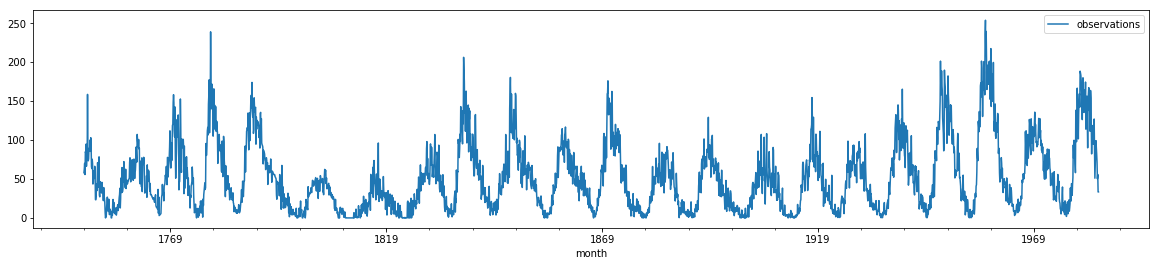

In [5]:
uni_df.plot(figsize=(20, 4))

### Data preparation

PyTorch provides tool for preparing data. It makes code more readable and reusable. 

In [43]:
def make_sequence(series, window):
    X, y = list(), list()
    size = len(series)
    for i in range(size):
        end_ix = i + window
        if end_ix > size - 1:
            break
        seq_x, seq_y = series[i:end_ix], series[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return (np.array(X, dtype=np.float32), np.array(y, dtype=np.float32))

def prepare_dataset(series, window):
    X, y = make_sequence(series, window)
    return torch.from_numpy(X), torch.from_numpy(y)

In [44]:
threshold_month = '1939-11-01'
window = 10
D_in = window

X_train, y_train = prepare_dataset(uni_df[uni_df.index <= threshold_month].values, window)
X_test, y_test = prepare_dataset(uni_df[uni_df.index > threshold_month].values, window)

Data set needs to be splitted to train and test sets. Torch has good tool from sampling 

In [45]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

### One-Dimensional Convolutional Neural Network Model (1D CNN)

1D CNN is a model that has convolutional hidden layer that calculates over one dimensional sequence. 

Select device.

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda'

print(torch.cuda.get_device_name(0))

GeForce GTX 1060


In [57]:
m = nn.Conv1d(4, 10, 1)
feature_maps1 = m(inputs)
print(feature_maps1.size())

RuntimeError: Given groups=1, weight of size [10, 4, 1], expected input[4, 10, 1] to have 4 channels, but got 10 channels instead

In [47]:
class OneDCNN(nn.Module):
    def __init__(self, d_in):
        super(OneDCNN, self).__init__()
        self.d_in = d_in
        self.conv1 = nn.Conv1d(D_in, 16, 3)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64, 50)
        self.fc2 = nn.Linear(50, 1)
    
    def forward(self, x):
        x = x
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
one_dcnn = OneDCNN(D_in).to(device)
one_dcnn

OneDCNN(
  (conv1): Conv1d(10, 16, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

Define a loss function and optimizer.

In [48]:
criterion = nn.MSELoss()
optimizer = optim.RMSprop(one_dcnn.parameters(), lr=0.0001)

Prepare train and test dataloader.

In [49]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, drop_last=True, num_workers=8, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, drop_last=False, num_workers=8, sampler=SequentialSampler(test_dataset))

Train network

In [52]:
one_dcnn.train()
n_epoch = 30
loss_history = list()
for epoch in range(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
#         pdb.set_trace()
        inputs, labels = data
        print(inputs.shape)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = one_dcnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / i))
    loss_history.append(running_loss )

torch.Size([4, 10, 1])


RuntimeError: sizes must be non-negative

The plot below shows loss error.

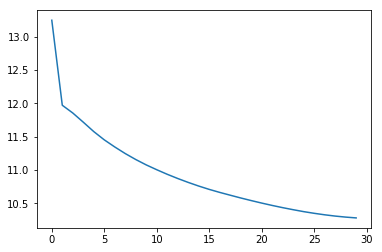

In [41]:
plt.plot(np.log(loss_history));

Validate the network

Predict new observations

In [46]:
one_dcnn.eval()
test_loss = 0
correct = 0
predictions = list()
features = list()
labels = list()
with torch.no_grad():
    for data, target in test_loader:
        features.append(data)
        predictions.append(one_dcnn(data.to(device)))
        labels.append(target)
        
predictions = np.array(list(map(lambda x: x.to('cpu').numpy(), predictions))).flatten()
labels = np.array(list(map(lambda x: x.numpy(), labels))).flatten()
features  = np.array(list(map(lambda x: x.numpy(), features))).reshape(-1, D_in)

RuntimeError: size mismatch, m1: [1 x 48], m2: [64 x 50] at /opt/conda/conda-bld/pytorch_1533672544752/work/aten/src/THC/generic/THCTensorMathBlas.cu:249

The plot shows observations and predictions for testing period.

In [43]:
features.shape, test_df.shape

((516, 10), (524, 4))

In [44]:
uni_df[uni_df.index > threshold_month]

,observations
month,
1939-12-01,42.1
1940-01-01,50.5
1940-02-01,59.4
1940-03-01,83.3
1940-04-01,60.7
1940-05-01,54.4
1940-06-01,83.9
1940-07-01,67.5
1940-08-01,105.5


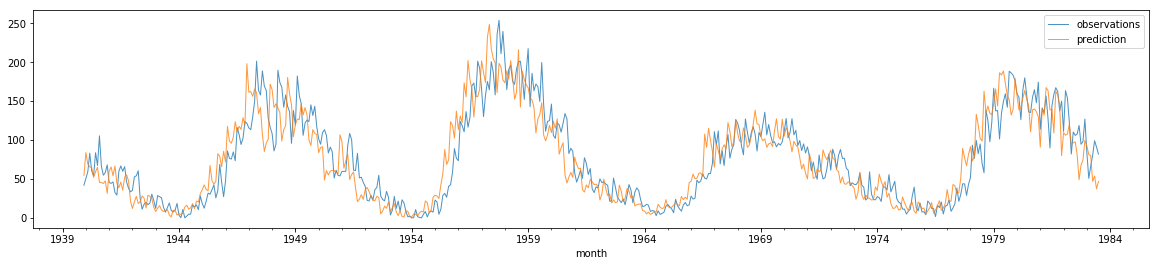

In [32]:
test_df = uni_df[uni_df.index > threshold_month].loc['1939-12-01':'1983-07-01', :]
test_df.loc[:, 'features'] = list(map(lambda x: ', '.join(map(str, x)), features))
test_df['prediction'] = predictions
test_df['prediction'] = test_df['prediction']
test_df.drop('features', axis=1).plot(figsize=(20, 4), lw=1, alpha=0.8)

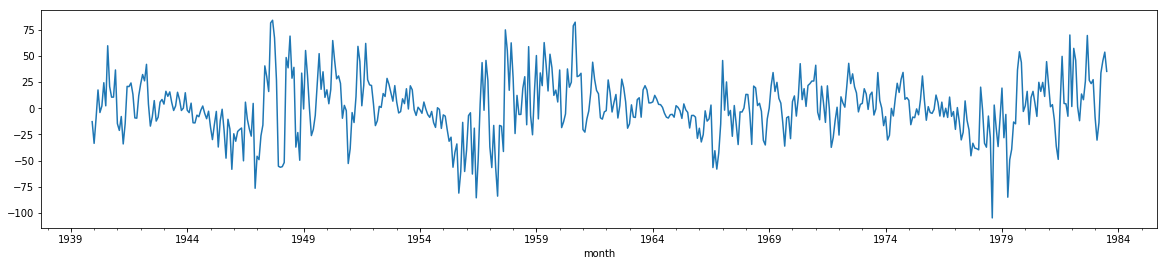

In [33]:
test_df['error'] = test_df['observations'] - test_df['prediction']
test_df.error.plot(figsize=(20, 4))

In [33]:
pd.set_option('display.max_colwidth', -1)
display(test_df[np.abs(test_df.error) >= 30])

,observations,features,prediction,error
month,,,,
1942-04-01,60.7,"59.8, 66.9, 60.0, 65.9, 46.3, 38.3, 33.7, 35.6, 52.8, 54.2, 60.7, 25.0",16.045126,44.654874
1945-08-01,25.9,"16.9, 10.8, 28.4, 18.5, 12.7, 21.5, 32.0, 30.6, 36.2, 42.6, 25.9, 34.9",69.410194,-43.510194
1945-10-01,68.8,"28.4, 18.5, 12.7, 21.5, 32.0, 30.6, 36.2, 42.6, 25.9, 34.9, 68.8, 46.0",26.008766,42.791234
1945-12-01,27.4,"12.7, 21.5, 32.0, 30.6, 36.2, 42.6, 25.9, 34.9, 68.8, 46.0, 27.4, 47.6",86.829185,-59.429185
1946-06-01,73.5,"25.9, 34.9, 68.8, 46.0, 27.4, 47.6, 86.2, 76.6, 75.7, 84.9, 73.5, 116.2",108.123924,-34.623924
1947-02-01,113.4,"75.7, 84.9, 73.5, 116.2, 107.2, 94.4, 102.3, 123.8, 121.7, 115.7, 113.4, 129.8",152.805679,-39.405679
1947-03-01,129.8,"84.9, 73.5, 116.2, 107.2, 94.4, 102.3, 123.8, 121.7, 115.7, 113.4, 129.8, 149.8",204.846313,-75.046313
1947-05-01,201.3,"116.2, 107.2, 94.4, 102.3, 123.8, 121.7, 115.7, 113.4, 129.8, 149.8, 201.3, 163.9",171.185577,30.114423
1947-10-01,163.6,"121.7, 115.7, 113.4, 129.8, 149.8, 201.3, 163.9, 157.9, 188.8, 169.4, 163.6, 128.0",120.480980,43.119020
